# Filter design


A filter is characterized by its impulse response $\{h_k\}_{k=1}^n$.  

Its frequency response $H : [0, \pi] \to \mathbb{C}$ is defined as

$$
H(\omega) = \sum_{k=1}^n h_k e^{-i \omega k},
$$

where $i = \sqrt{-1}$.  

In *magnitude filter design*, the goal is to find impulse response coefficients 
that meet certain specifications on the magnitude of the frequency response.  

We will consider a typical lowpass filter design problem, which can be expressed as

$$
\begin{array}{ll}
\text{minimize}   & U_{\text{stop}} \\[0.5em]
\text{subject to} & L_{\text{pass}} \leq |H(\pi l / N)| \leq U_{\text{pass}}, 
\quad l = 0, \ldots, l_{\text{pass}} - 1, \\[0.5em]
& |H(\pi l / N)| \leq U_{\text{pass}}, 
\quad l = l_{\text{pass}}, \ldots, l_{\text{stop}} - 1, \\[0.5em]
& |H(\pi l / N)| \leq U_{\text{stop}}, 
\quad l = l_{\text{stop}}, \ldots, N,
\end{array}
$$

where $h \in \mathbb{R}^n$ and $U_{\text{stop}} \in \mathbb{R}$ are the optimization 
cp.Variables. The passband magnitude limits $L_{\text{pass}}$ and $U_{\text{pass}}$ are 
given.


## Model definition

In [1]:
import cvxpy as cp
import matplotlib.pyplot as plt
import numpy as np

from dccp import is_dccp

N = 100
n = 10
l_pass = N // 2 - 15
l_stop = N // 2
L_pass = 0.9
U_pass = 1.1
omega = np.linspace(0, np.pi, N)
expo = []
for omg_ind in range(N):
    cosine = np.cos(np.dot(omega[omg_ind], range(0, n, 1)))
    sine = np.sin(np.dot(omega[omg_ind], range(0, n, 1)))
    expo.append(np.array([cosine, sine]))

h = cp.Variable(n)
U_stop = cp.Variable(1)
constr = []
for l in range(N):
    if l < l_pass:
        constr += [cp.norm(expo[l] @ h, 2) >= L_pass]
    if l < l_stop:
        constr += [cp.norm(expo[l] @ h, 2) <= U_pass]
    else:
        constr += [cp.norm(expo[l] @ h, 2) <= U_stop]

# solve the problem
prob = cp.Problem(cp.Minimize(U_stop), constr)
assert is_dccp(prob)
result = prob.solve(method="dccp", seed=0)
assert prob.status == cp.OPTIMAL
assert result is not None

## Visualize filter frequency response

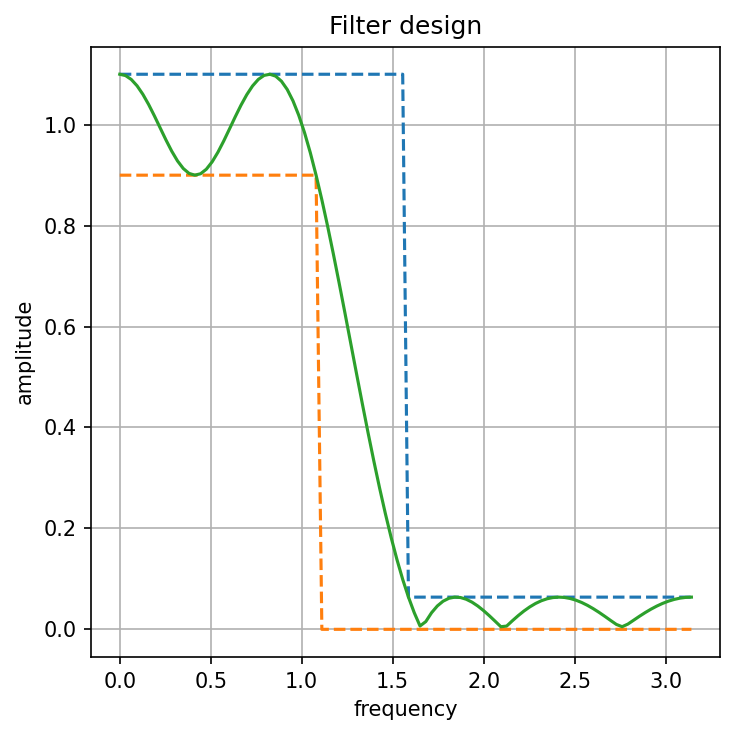

In [2]:
plt.figure(figsize=(5, 5), dpi=150)

lowerbound = np.zeros((N, 1))
lowerbound[0:l_pass] = L_pass * np.ones((l_pass, 1))
upperbound = np.ones((N, 1)) * U_stop.value
upperbound[0:l_stop] = U_pass * np.ones((l_stop, 1))
plt.plot(omega, upperbound, "--")
plt.plot(omega, lowerbound, "--")
H_amp = np.zeros((N, 1))

for l in range(N):
    H_amp[l] = cp.norm(expo[l] @ h, 2).value

plt.plot(omega, H_amp)
plt.xlabel("frequency")
plt.ylabel("amplitude")
plt.title("Filter design")
plt.grid()
plt.tight_layout()